In [1]:
#import required libraries
import torch
import pandas as pd
import umap.umap_ as umap
from sklearn.decomposition import PCA
from transformers import AutoTokenizer
import matplotlib.pyplot as plt, numpy as np
from transformers import AutoModelForMaskedLM
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

2022-08-03 13:31:43.768573: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tokenizer = AutoTokenizer.from_pretrained("Tokenizers/fine_tuned_bert_tokenizer_small/alloy-data-tokenizer")
model = AutoModelForMaskedLM.from_pretrained("temp_model/checkpoint-90000", output_hidden_states = True)

In [3]:
#a helper function that takes a list of material forumals and return token and segment tensors to be used for BERT model to get embeddings
def prepare_tokens(materials):
    
    tokens_tensors = []
    segments_tensors = []
    
    for material in materials:
        
        material = "[CLS] " + material + " [SEP]"
        tokenized_text = tokenizer.tokenize(material)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensor = torch.tensor([segments_ids])
        
        tokens_tensors.append(tokens_tensor)
        segments_tensors.append(segments_tensor)
        
    return tokens_tensors, segments_tensors

#a helper function that takes a list of token tensors and another list of segment tensors and returns BERT embeddings for all materials
def get_embeddings(tokens_tensors, segments_tensors):
    all_embeddings = []
    for i in range(len(tokens_tensors)):
        outputs = model(tokens_tensors[i], segments_tensors[i])
        hidden_states = outputs[1]
        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        sentence_embedding =sentence_embedding.detach().numpy()
        all_embeddings.append(sentence_embedding)
    return all_embeddings

#a helper function to read the alloys data
def get_data(path):
    
    data = pd.read_csv(path)
    alloys_x = list(data['Alloy'])
    alloys_y = list(data['Phase'])
    print('There is a total of {} materials, of which {} are BCC, {} are FCC, {} are HCP, and {} are multi-phase'.format(len(data), alloys_y.count('bcc'), alloys_y.count('fcc'), alloys_y.count('hcp'), alloys_y.count('multi-phase')))
    
    return alloys_x, alloys_y


In [4]:
fcc_materials = ["VCrMnFeCo", "VCrMnFeNi", "VCrMnFeCu", "VCrMnCoNi", "VCrMnCoCu", "VCrMnNiCu", "VCrFeCoNi", "VCrFeCoCu", "VCrFeNiCu", "VCrCoNiCu", "VMnFeCoNi", "VMnFeCoCu", "vMnFeNiCu", "VMnCoNiCu", "VFeCoNiCu", "CrMnFeCoNi", "CrMnFeCoCu", "CrMnFeNiCu", "CrMnCoNiCu", "CrFeCoNiCu", "MnFeCoNiCu"]
bcc_materials = ["TiZrNbMoHf", "TiZrNbMoTa", "TiZrNbMoW", "TiZrNbHfTa", "TiZrNbHfW", "TiZrNbTaW", "TiZrMoHfTa", "TiZrMoHfW", "TiZrMoTaW", "TiZrHfTaW", "TiNbMoHfTa", "TiNbMoHfW", "TiNbMoTaW", "TiNbHfTaW", "TiMoHfTaW", "ZrNbMoHfTa", "ZrNbMoHfW", "ZrNbMoTaW", "ZrNbHfTaW", "ZrMoHfTaW", "NbMoHfTaW"]
all_materials = fcc_materials + bcc_materials
fcc_labels = ["fcc"]*len(fcc_materials)
bcc_labels = ["bcc"]*len(bcc_materials)
all_labels = fcc_labels + bcc_labels

In [5]:
model.eval()
tokens_tensors, segments_tensors = prepare_tokens(all_materials)
all_embeddings = get_embeddings(tokens_tensors, segments_tensors)

/home/ml-art/.local/lib/python3.10/site-packages/umap/spectral.py:227: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  warn(


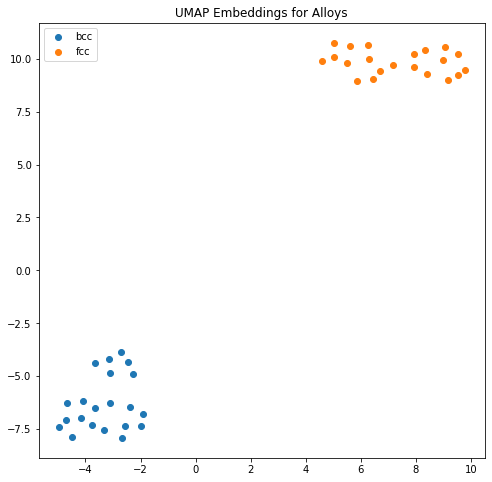

In [6]:
#using umap to reduce the embeddings dimensionality and plotting the results

umap_embedding = umap.UMAP(n_neighbors=12,n_components=2, min_dist=0.5, random_state=72).fit_transform(all_embeddings)

fig = plt.figure(figsize=(8, 8))

for label in np.unique(all_labels):
    indices = np.where(np.array(all_labels) == label)[0]
    umap_embeddings_class = umap_embedding[indices]

    plt.scatter(umap_embeddings_class[:,1], umap_embeddings_class[:,0],label=str(label))
    plt.title('UMAP Embeddings for Alloys')
    plt.legend()


plt.show()

In [ ]:
#read the data and get the embeddings of all the materials
model.eval()
alloys_x, alloys_y = get_data("Alloys_Phases.csv")
tokens_tensors, segments_tensors = prepare_tokens(alloys_x)
all_embeddings = get_embeddings(tokens_tensors, segments_tensors)

There is a total of 1252 materials, of which 261 are BCC, 218 are FCC, 146 are HCP, and 627 are multi-phase


In [ ]:
#using umap to reduce the embeddings dimensionality and plotting the results

umap_embedding = umap.UMAP(n_neighbors=12,n_components=2, min_dist=0.5, random_state=72).fit_transform(all_embeddings)

fig = plt.figure(figsize=(8, 8))

for label in np.unique(alloys_y):
    indices = np.where(np.array(alloys_y) == label)[0]
    umap_embeddings_class = umap_embedding[indices]

    plt.scatter(umap_embeddings_class[:,1], umap_embeddings_class[:,0],label=str(label))
    plt.title('UMAP Embeddings for Alloys')
    plt.legend()


plt.show()

In [84]:
#changing the alloys labels from strings to integers
ord_enc = OrdinalEncoder()
alloys_y_num = ord_enc.fit_transform(np.asarray(alloys_y).reshape(-1, 1))
alloys_y_num = np.squeeze(alloys_y_num)

#splitting the dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(umap_embedding, alloys_y_num, test_size=0.25)

(1252,)


In [113]:
#building and training a KNN classifer
KNN_model = KNeighborsClassifier(n_neighbors=3)
KNN_model.fit(x_train, y_train)

In [127]:
#using the trained model to predict the crystal structue of alloys in the test set and prinintg the classification report
KNN_prediction = KNN_model.predict(x_test)
print(classification_report(KNN_prediction, y_test))

              precision    recall  f1-score   support

         0.0       0.65      0.57      0.61        65
         1.0       0.54      0.71      0.61        42
         2.0       0.50      0.47      0.49        38
         3.0       0.98      0.96      0.97       168

    accuracy                           0.79       313
   macro avg       0.67      0.68      0.67       313
weighted avg       0.79      0.79      0.79       313

